<a href="https://colab.research.google.com/github/pren1/VAST/blob/master/VTB_classifier_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf VAST/
!git clone https://github.com/pren1/VAST.git
!pip3 install soundfile
!pip3 install librosa

Cloning into 'VAST'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 82 (delta 34), reused 50 (delta 18), pack-reused 0
Unpacking objects: 100% (82/82), done.


In [0]:
from VAST.util import *
import pdb
import pprint
from tqdm import tqdm
import numpy as np
import IPython
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import os

### Prepare dataset

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

# !gdown https://drive.google.com/uc?id=14AT3AGwNtPMRaFGN7VE2rf2BHrN4ImSd
# !gdown https://drive.google.com/uc?id=16124JngZYtz-xt5p_KBdsuo4lXN-TDCW

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data_folder = "gdrive/My Drive/CLIPPED_VAST/"
label_folder = "gdrive/My Drive/CLIPPED_VAST/"

In [5]:
data = []
label = []
for i in tqdm(range(6)):
  data.append(load_data_array_from_npy(data_folder + f"dataset_{i}.npy"))
  label.extend(load_data_array_from_npy(label_folder + f"labelset_{i}.npy"))
data = np.vstack(data)

100%|██████████| 6/6 [04:23<00:00, 43.87s/it]


In [6]:
data.shape

(175566, 8000)

In [7]:
len(label)

175566

In [0]:
# vtb_audio = "gdrive/My Drive/VAST/"
# data = load_data_array_from_npy(f"{vtb_audio}/one_second_data.npy")
# label = load_data_array_from_npy(f"{vtb_audio}/one_second_label.npy")

# data = load_data_array_from_npy("one_second_data.npy")
# label = load_data_array_from_npy("one_second_label.npy")
# print(f"data shape: {data.shape}")
# print(f"label shape: {label.shape}")

### Take a look at the loaded data

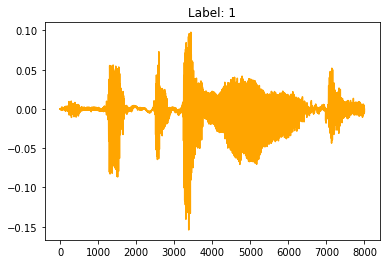

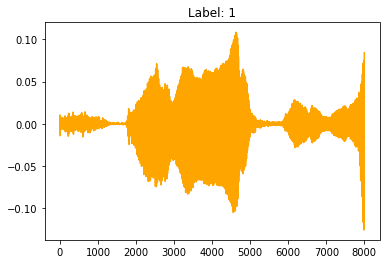

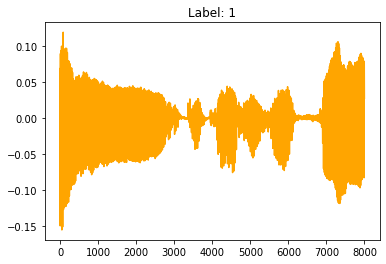

In [9]:
for i in range(3):
  plt.plot(data[i], color = 'orange', label='read in sample data')
  plt.title(f"Label: {label[i]}")
  plt.show()
  IPython.display.display(IPython.display.Audio(np.asarray(data[i]).T, rate=8000))

### See if the preprocess part works correct

In [0]:
sample_rate = 8000

In [11]:
from keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melspecModel = Sequential() 

melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, data.shape[-1]),
                         padding='same', sr=sample_rate, n_mels=80,
                         fmin=40.0, fmax=sample_rate/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )

melspecModel.add(Normalization2D(int_axis=0))

melspecModel.summary()

Using TensorFlow backend.


tracking <tf.Variable 'mel_stft/real_kernels:0' shape=(1024, 1, 1, 513) dtype=float32> dft_real_kernels
tracking <tf.Variable 'mel_stft/imag_kernels:0' shape=(1024, 1, 1, 513) dtype=float32> dft_imag_kernels
tracking <tf.Variable 'mel_stft/Variable:0' shape=(513, 80) dtype=float32> freq2mel
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mel_stft (Melspectrogram)    (None, 80, 63, 1)         1091664   
_________________________________________________________________
normalization2d_1 (Normaliza (None, 80, 63, 1)         0         
Total params: 1,091,664
Trainable params: 1,091,664
Non-trainable params: 0
_________________________________________________________________


test_input shape: (1, 1, 8000)
melspec shape: (1, 80, 63, 1)


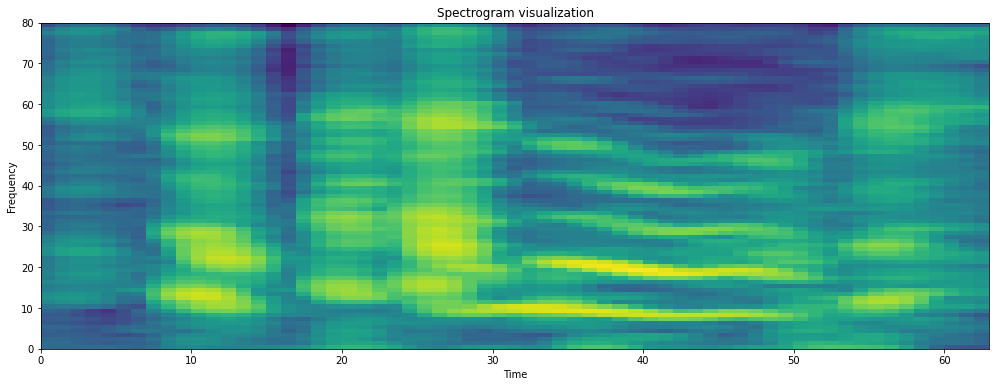

In [12]:
test_input = np.expand_dims(np.expand_dims(data[0], 0), 0)
print(f"test_input shape: {test_input.shape}")
melspec = melspecModel.predict(test_input)
print(f"melspec shape: {melspec.shape}")

plt.figure(figsize=(17,6))
plt.pcolormesh(melspec[0,:,:,0])

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

### Check if mel spectrogram matches the one computed with librosa

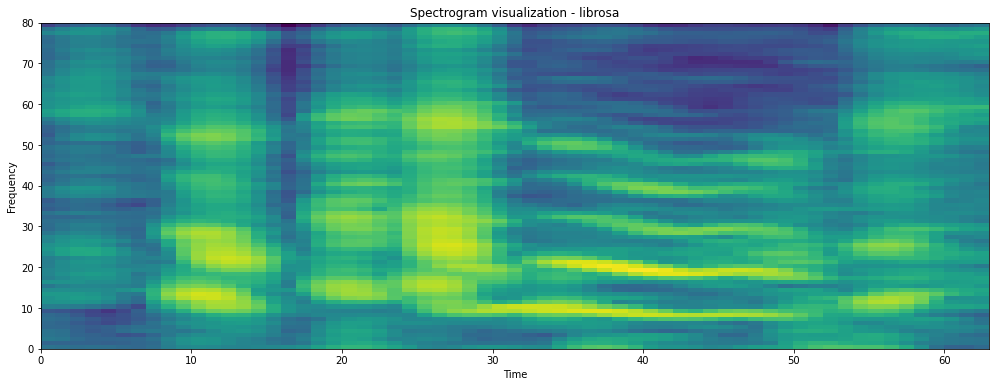

In [13]:
librosa_melspec = librosa.feature.melspectrogram(y=data[0], sr=sample_rate, n_fft=1024,
                                                 hop_length=128, power=1.0, #window='hann',
                                                 n_mels=80, fmin=40.0, fmax=sample_rate/2)
S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)
plt.figure(figsize=(17,6))
plt.pcolormesh(S_dB)

plt.title('Spectrogram visualization - librosa')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

### Split train set & test set

In [14]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

'Turn to one-hot'
label = to_categorical(label)
data, X_test, label, y_test = train_test_split(data, label, test_size=0.2, random_state=42)
print(f"X_train shape: {data.shape}")
print(f"y_test[0]: {y_test[0]}")

X_train shape: (140452, 8000)
y_test[0]: [0. 0. 0. 1.]


### A toy CNN + LSTM + attention classifier 

In [0]:
from keras import layers as L
import keras.backend as K
from keras.models import Model
from keras.callbacks import LearningRateScheduler
import math

'define model'
def AttRNNSpeechModel(nCategories, dropout_rate, samplingrate=8000,
                      inputLength=8000, rnn_func=L.LSTM):
    # simple LSTM
    sr = samplingrate
    iLen = inputLength
    dropout_rate = dropout_rate

    inputs = L.Input((inputLength,), name='input')

    x = L.Reshape((1, -1))(inputs)

    m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                       padding='same', sr=sr, n_mels=80,
                       fmin=40.0, fmax=sr / 2, power_melgram=1.0,
                       return_decibel_melgram=True, trainable_fb=False,
                       trainable_kernel=False,
                       name='mel_stft')
    m.trainable = False

    x = m(x)

    x = Normalization2D(int_axis=0, name='mel_stft_norm')(x)

    # note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
    # we would rather have it the other way around for LSTMs

    x = L.Permute((2, 1, 3))(x)

    x = L.Conv2D(10, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Dropout(dropout_rate)(x)
    
    x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Dropout(dropout_rate)(x)

    # x = Reshape((125, 80)) (x)
    # keras.backend.squeeze(x, axis)
    x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)

    x = L.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)  # [b_s, seq_len, vec_dim]
    
    x = L.Dropout(dropout_rate)(x)                    
    x = L.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)  # [b_s, seq_len, vec_dim]

    xFirst = L.Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
    query = L.Dense(128)(xFirst)

    # dot product attention
    attScores = L.Dot(axes=[1, 2])([query, x])
    attScores = L.Softmax(name='attSoftmax')(attScores)  # [b_s, seq_len]

    # rescale sequence
    attVector = L.Dot(axes=[1, 1])([attScores, x])  # [b_s, vec_dim]

    x = L.Dense(64, activation='relu')(attVector)
    x = L.Dense(32)(x)

    output = L.Dense(nCategories, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs], outputs=[output])

    return model

'learning rate decay'
def step_decay(self, epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 2.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate    

In [16]:
model = AttRNNSpeechModel(4, dropout_rate=0.1)
model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['categorical_accuracy'])
model.summary()
lrate = LearningRateScheduler(step_decay)

tracking <tf.Variable 'mel_stft_1/real_kernels:0' shape=(1024, 1, 1, 513) dtype=float32> dft_real_kernels
tracking <tf.Variable 'mel_stft_1/imag_kernels:0' shape=(1024, 1, 1, 513) dtype=float32> dft_imag_kernels
tracking <tf.Variable 'mel_stft_1/Variable:0' shape=(513, 80) dtype=float32> freq2mel
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 8000)         0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 8000)      0           input[0][0]                      
__________________________________________________________________________________________________
mel_stft (Melspectrogram)       (None, 80, 63, 1)    1091664     reshape_1[0][0]           

In [17]:
import gc
gc.collect()

4841

### Train model

In [18]:
results = model.fit(x = data, y = label,
				epochs=25,
				batch_size=1024,
				shuffle=True,
				validation_data=(X_test, y_test),
				callbacks=[lrate]
				)

Train on 140452 samples, validate on 35114 samples
Epoch 1/25
140452/140452 [==============================] - 70s 502us/step - loss: 0.4511 - categorical_accuracy: 0.8248 - val_loss: 1.8785 - val_categorical_accuracy: 0.2966
Epoch 2/25
140452/140452 [==============================] - 68s 482us/step - loss: 0.1734 - categorical_accuracy: 0.9389 - val_loss: 0.3597 - val_categorical_accuracy: 0.8658
Epoch 3/25
140452/140452 [==============================] - 68s 484us/step - loss: 0.1268 - categorical_accuracy: 0.9557 - val_loss: 0.1286 - val_categorical_accuracy: 0.9548
Epoch 4/25
140452/140452 [==============================] - 68s 483us/step - loss: 0.0982 - categorical_accuracy: 0.9652 - val_loss: 0.1018 - val_categorical_accuracy: 0.9662
Epoch 5/25
140452/140452 [==============================] - 68s 481us/step - loss: 0.0842 - categorical_accuracy: 0.9706 - val_loss: 0.0780 - val_categorical_accuracy: 0.9724
Epoch 6/25
140452/140452 [==============================] - 68s 482us/step

### Training loss/acc curve

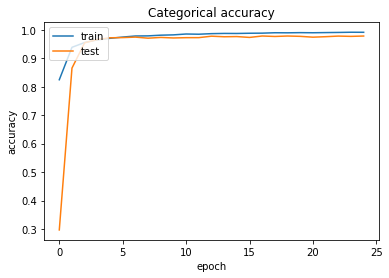

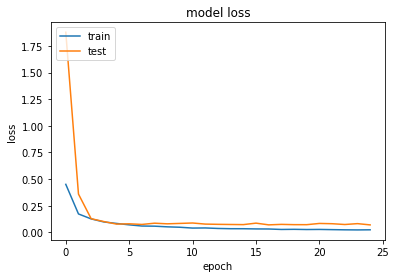

In [19]:
# summarize history for categorical accuracy
plt.plot(results.history['categorical_accuracy'])
plt.plot(results.history['val_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Draw confusion matrix

In [0]:
from sklearn.metrics import confusion_matrix
# Get y_pred_test
four_class_probs = model.predict(X_test)
y_pred = np.argmax(four_class_probs, axis=-1)
y_test = np.argmax(y_test, axis=-1)
confusion_mat = confusion_matrix(y_test, y_pred)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


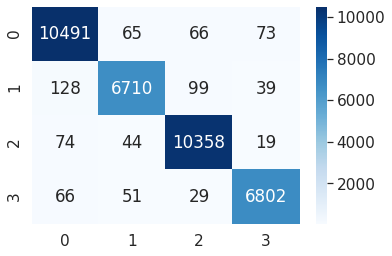

In [21]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_mat, range(confusion_mat.shape[0]), range(confusion_mat.shape[1]))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
plt.show()